In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [4]:
# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch Tensor (0-1 range)
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download and load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders for batch processing
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.16MB/s]


In [5]:
# Define a simple feedforward neural network
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),           # Convert 28x28 image to 784 vector
            nn.Linear(784, 128),    # Hidden layer with 128 neurons
            nn.ReLU(),              # Activation function
            nn.Linear(128, 64),     # Second hidden layer
            nn.ReLU(),
            nn.Linear(64, 10)       # Output layer: 10 classes (digits 0-9)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model
model = DigitClassifier()


In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Good for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Set number of epochs
epochs = 5

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


KeyboardInterrupt: 

In [5]:
# Evaluate model accuracy on test data
correct = 0
total = 0

# Disable gradient calculation (we're not training)
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 96.90%


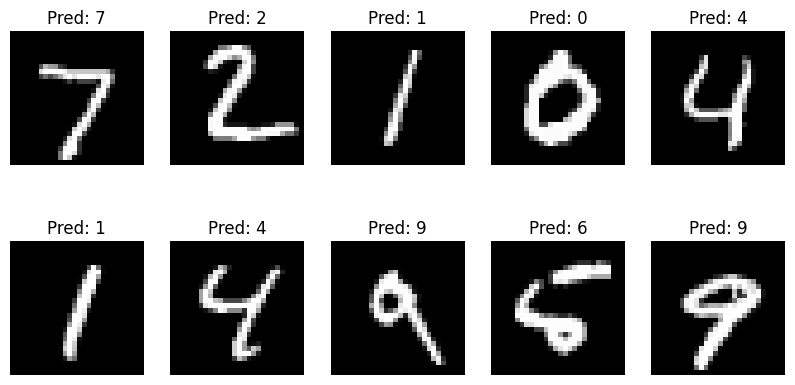

In [7]:
import matplotlib.pyplot as plt

# Get a batch of test images
images, labels = next(iter(test_loader))

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot 10 images with their predictions
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Pred: {predicted[i].item()}', fontsize=12)
    ax.axis('off')

plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Create model instance
cnn_model = CNNClassifier()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train the CNN model
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.1718
Epoch [2/5], Loss: 0.0472
Epoch [3/5], Loss: 0.0353
Epoch [4/5], Loss: 0.0244
Epoch [5/5], Loss: 0.0191


In [9]:
correct = 0
total = 0

cnn_model.eval()  # Evaluation mode (turns off dropout, batchnorm if present)

with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_accuracy = 100 * correct / total
print(f"CNN Test Accuracy: {cnn_accuracy:.2f}%")


CNN Test Accuracy: 99.05%


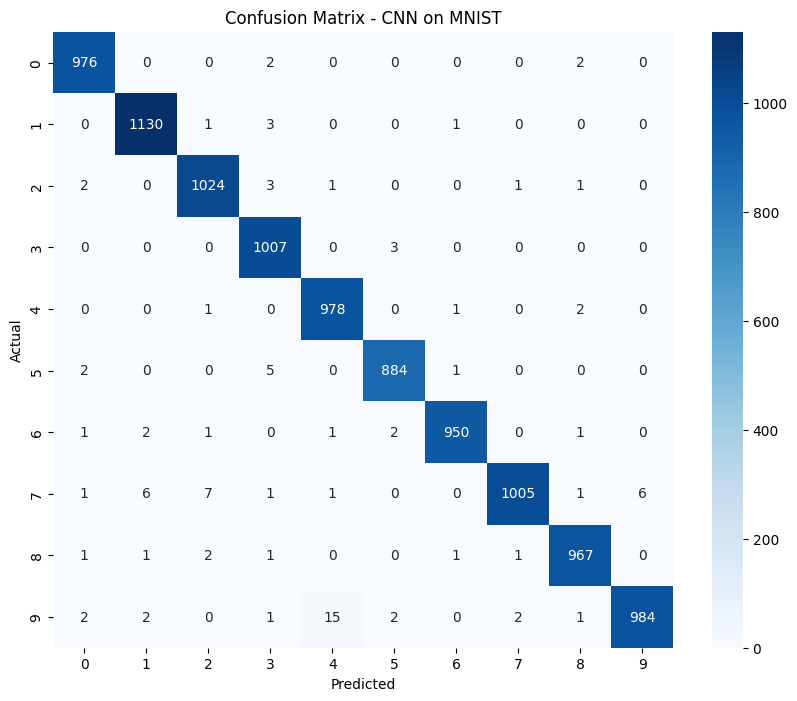

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN on MNIST')
plt.show()


In [13]:
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 25.2 MB/s eta 0:00:00


In [14]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import models, transforms


In [15]:
misclassified_samples = []

cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)

        # Find misclassified images
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_samples.append((images[i], labels[i], predicted[i]))

# Select the first misclassified sample
sample_image, true_label, predicted_label = misclassified_samples[0]
print(f"True Label: {true_label}, Predicted: {predicted_label}")


True Label: 4, Predicted: 2


In [16]:
from torch.autograd import Function

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, image, target_class):
        self.model.zero_grad()
        output = self.model(image.unsqueeze(0))
        loss = output[:, target_class]
        loss.backward()

        # Compute Grad-CAM
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze(0)
        cam = F.relu(cam)  # Only keep positive activations

        # Normalize and resize
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cv2.resize(cam.detach().numpy(), (28, 28))

        return cam


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


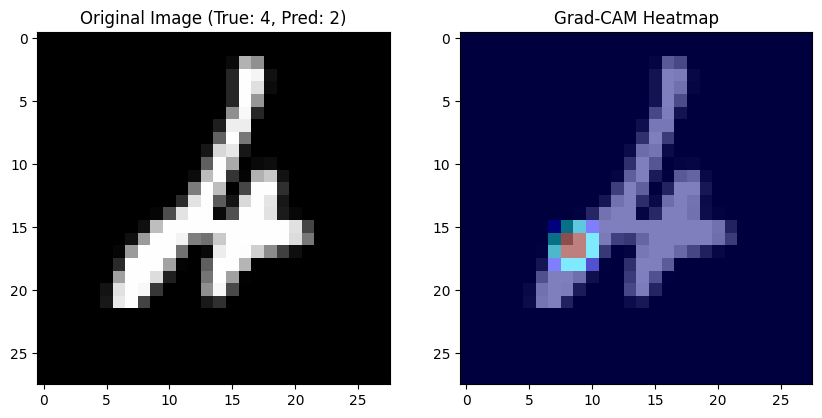

In [19]:
# Select the last convolutional layer

target_layer = cnn_model.conv_layers[3]


grad_cam = GradCAM(cnn_model, target_layer)

# Generate heatmap
heatmap = grad_cam.generate_heatmap(sample_image, predicted_label.item())

# Convert image for visualization
image_np = sample_image.squeeze().numpy()

# Overlay heatmap on original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np, cmap='gray')
plt.title(f"Original Image (True: {true_label}, Pred: {predicted_label})")

plt.subplot(1, 2, 2)
plt.imshow(image_np, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM Heatmap")
plt.show()


In [18]:
print(cnn_model)


CNNClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
